# Cohort 240 MMK AUCs analysis

### Imports and environment setup

- Date of run: 2024-09-19
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Utils imports
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)


# Data loading and preprosessing

The original excel file (available [here](<https://mimarkdx.sharepoint.com/:x:/s/Scientific/ESh2d12eFKVCi0_fbjrINmQBCBuutU-z5ni4lsReuJA-5w?e=WFNgxI>)) was saved into a CSV file in the data folder of this repository (available [here](<../data/mmk_240_20240919.csv>)), as a CSV.

In [4]:
df_240 = pd.read_csv('../data/mmk_240_20240926.csv', sep=',', index_col=0, header=0)

In [5]:
# Harmonization of column names
df_240 = utils.normalize_column_names(df_240)

# To harmonize with other analyses, change _MIMARK to _MMK in column names
df_240.columns = [col.replace('_MIMARK', '_MMK') for col in df_240.columns]

In [6]:
# Ensure numeric columns are treated as such
cols_240_to_num = ['TP_2022', 'AGRIN_MMK', 'KPYM_MMK', 'HSPB1_MMK',
                   'PERM_MMK', 'MMP9_MMK', 'TP_2024']
df_240 = utils.cols_as_numbers(df_240, cols_240_to_num)


In [7]:
# Rename Condition column to Pathology
df_240.rename(columns={'Condition': 'Pathology'}, inplace=True)

# Ensure categorical columns are treated as such
df_240 = utils.cols_as_category(df_240, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})

# Execution parameters

In [8]:
PLOT_ROCS = True
MAX_BIOMARKER_COUNT = 3
RESULTS_PATH = '../data/results/240_MMK_2024'

# Columns to be considered as biomarkers
BIOMARKERS_240 = ['AGRIN_MMK', 'KPYM_MMK', 'HSPB1_MMK',
                   'PERM_MMK', 'MMP9_MMK']

NORMALIZING_COL_240 = 'TP_2024' # Column to be used for normalizing the biomarkers

## Methods

Description of the methods used to compute the AUCS

### Direct

No transformations were made to the readout of each biomarker.

Due to the different treatment the samples have undergone, the performance of the biomarkers in the 60x60 is masking the correlation of the target variable (disease) with the volume variable because the biomarkers (and total protein) readouts correlate with the collected volume. While the volume is a good classification variable, we want to get rid of it because we cannot control it.  

### Normalized

To get rid of the volume, the total protein variable was proposed as a normalizing variable. The values used for classification are then the ratios of the concentrations $[Bmk]/[TP]$.

After discussions with the collaborators from Santiago, they noted the fact that ratios can be misleading, especially if the denominator variable is not independent of the numerator or other variables in the analysis. 



In [9]:
METHODS = ['direct', 'normalized']

# Computing the models

All the functions to generate the models are included in the [cohort_analysis_utils.py](../code/cohort_analysis_utils.py) file.

In [10]:
models_240_with_cis = utils.compute_all_models_and_save(
                            df=df_240,
                            biomarkers=BIOMARKERS_240,
                            normalizing_col=NORMALIZING_COL_240, 
                            volume_col= None,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=MAX_BIOMARKER_COUNT,
                            folder_name=RESULTS_PATH,
                            plot_rocs=PLOT_ROCS,
                            auc_threshold=0.4,
                            )

In [11]:
# For individual biomarkers, compute the confidence intervals 

models_240_with_cis = utils.compute_all_models_and_save(
                            df=df_240,
                            biomarkers=BIOMARKERS_240,
                            normalizing_col=NORMALIZING_COL_240, 
                            volume_col= None,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=1,
                            folder_name=RESULTS_PATH,
                            plot_rocs=PLOT_ROCS,
                            compute_auc_ci=True,
                            auc_threshold=0.4,
                            )

## Running other analyses

### Create scatterplots for all the pairs of biomarkers

In [12]:
for biomarker1 in BIOMARKERS_240:
    for biomarker2 in BIOMARKERS_240[BIOMARKERS_240.index(biomarker1)+1:]:
        utils.plot_scatter_to_file(df_240, 
                                biomarker1, 
                                biomarker2, 
                                normalizing_col=NORMALIZING_COL_240, 
                                apply_log_x=True,
                                apply_log_y=True,
                                hue='Pathology', 
                                folder=RESULTS_PATH+'/scatters/')

# Results

## Direct

Here are presented results for the __direct__ method. Remember you can see the full results [here](<../data/results/240_MMK_2024/direct/max_3.csv>) (they are stored in the folder "data/results/240_MMK_2024/direct/").

In [13]:
df_results_240_direct = pd.read_csv(RESULTS_PATH+'/direct/max_3.csv', sep=',', header=0)
df_results_240_direct[['Biomarker_1','Biomarker_2','Biomarker_3','AUC']].head(n=10)


,Biomarker_1,Biomarker_2,Biomarker_3,AUC
0,MMP9_MMK,NaN,NaN,0.81886
1,PERM_MMK,NaN,NaN,0.79498
2,KPYM_MMK,HSPB1_MMK,MMP9_MMK,0.77609
3,KPYM_MMK,NaN,NaN,0.77424
4,AGRIN_MMK,HSPB1_MMK,MMP9_MMK,0.76285
5,KPYM_MMK,HSPB1_MMK,PERM_MMK,0.75943
6,HSPB1_MMK,MMP9_MMK,NaN,0.75702
7,HSPB1_MMK,PERM_MMK,MMP9_MMK,0.75672
8,AGRIN_MMK,HSPB1_MMK,PERM_MMK,0.73729
9,AGRIN_MMK,NaN,NaN,0.73446


Let's see also how the biomarkers performed individually.

In [14]:
df_results_240_direct[df_results_240_direct['Biomarker_2'].isnull() & df_results_240_direct['Biomarker_3'].isnull()][['Biomarker_1','AUC']]

,Biomarker_1,AUC
0,MMP9_MMK,0.81886
1,PERM_MMK,0.79498
3,KPYM_MMK,0.77424
9,AGRIN_MMK,0.73446
23,HSPB1_MMK,0.63160


## Normalized

Here are presented results for the __normalized__ method. Remember you can see the full results [here](<../data/results/240_MMK_2024/normalized/max_3.csv>) (they are stored in the folder "data/results/240_MMK_2024/direct/").

In [15]:
df_results_240_normalized = pd.read_csv(RESULTS_PATH+'/normalized/max_3.csv', sep=',', header=0)
df_results_240_normalized[['Biomarker_1','Biomarker_2','Biomarker_3','AUC']].head(n=10)

,Biomarker_1,Biomarker_2,Biomarker_3,AUC
0,MMP9_MMK,NaN,NaN,0.77079
1,KPYM_MMK,HSPB1_MMK,MMP9_MMK,0.75849
2,AGRIN_MMK,HSPB1_MMK,MMP9_MMK,0.75336
3,HSPB1_MMK,MMP9_MMK,NaN,0.74318
4,KPYM_MMK,HSPB1_MMK,PERM_MMK,0.74077
5,PERM_MMK,NaN,NaN,0.73968
6,HSPB1_MMK,PERM_MMK,MMP9_MMK,0.73874
7,AGRIN_MMK,HSPB1_MMK,PERM_MMK,0.73185
8,KPYM_MMK,NaN,NaN,0.71404
9,AGRIN_MMK,PERM_MMK,MMP9_MMK,0.71218


In [16]:
df_results_240_normalized[df_results_240_normalized['Biomarker_2'].isnull() & df_results_240_normalized['Biomarker_3'].isnull()][['Biomarker_1','AUC']]

,Biomarker_1,AUC
0,MMP9_MMK,0.77079
5,PERM_MMK,0.73968
8,KPYM_MMK,0.71404
19,AGRIN_MMK,0.69282
24,HSPB1_MMK,0.57531


## ROC curves

All the ROC curves for all the methods over all the combinations in all the cohorts were computed. If you want to check any ROC curve, the folder structure is the following: "data/results/240_MMK_2024/<"method">/<max_biomarkers>/rocs/. 

What we have observed is that, if we set as a threshold 0.95 sensitivity, this comes at the price of poor specificity. Just as an example, let’s take a look to the best scored biomarker, MMP9, using _direct_ method. This ROC image is located at "data/results/240_MMK_2024/direct/max_3/rocs/MMP9_MMK.png". 

 

In [17]:
roc_image_path = RESULTS_PATH+"/direct/max_3/rocs/MMP9_MMK.png"
display(HTML("<img src='"+roc_image_path+"'>"))


All the sensitivities and specificities for all the tresholds are located in the same folder, in CSV files.


## AUCs confidence interval

AUCs confidence intervals are computed with the bootstraping method. Bootstrapping to compute confidence intervals for AUC involves repeatedly resampling the original dataset with replacement to create many bootstrap samples, calculating the AUC for each sample, and then constructing a distribution of these AUC values. The confidence interval is determined by taking the appropriate percentiles (e.g., 2.5th and 97.5th for a 95% CI) from the sorted bootstrap AUC values, providing a range that estimates where the true AUC likely falls.

In [18]:
aucs = []
auc_cis = []
models = []

models_with_cis = models_240_with_cis['direct'][(list(models_240_with_cis['direct'].keys())[0])]

for model in models_with_cis.keys():
    model_name = model[0]
    model_auc = models_with_cis[model]['auc']
    model_auc_ci = models_with_cis[model]['auc_ci']
    aucs.append(float(model_auc))
    auc_cis.append([float(model_auc_ci[0]), float(model_auc_ci[1])])
    models.append(model_name)

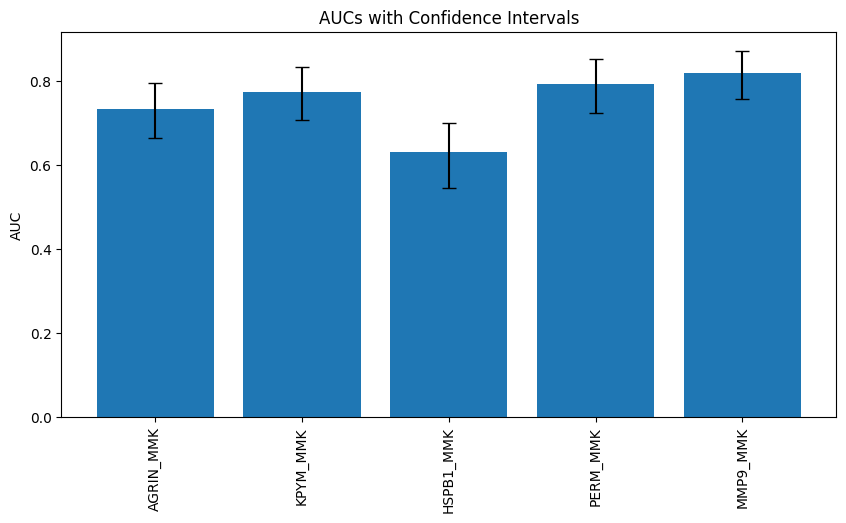

In [19]:
auc_cis = np.array(auc_cis)

# Calculate the errors
lower_err = aucs - auc_cis[:, 0]
upper_err = auc_cis[:, 1] - aucs
yerr = [lower_err, upper_err]

plt.figure(figsize=(10,5))
plt.bar(models, aucs, yerr=yerr, capsize=5, align='center')
plt.xticks(rotation=90)
plt.ylabel('AUC')
plt.title('AUCs with Confidence Intervals')
plt.show()

# Distribution of biomarkers by condition (log transformed)

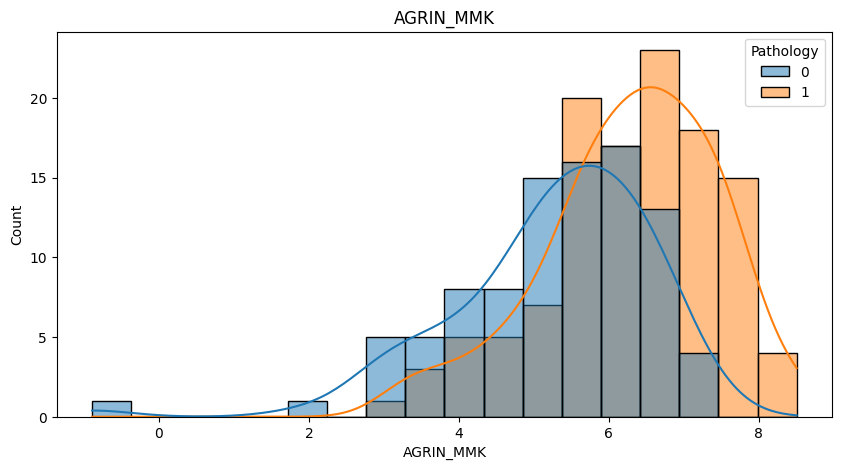

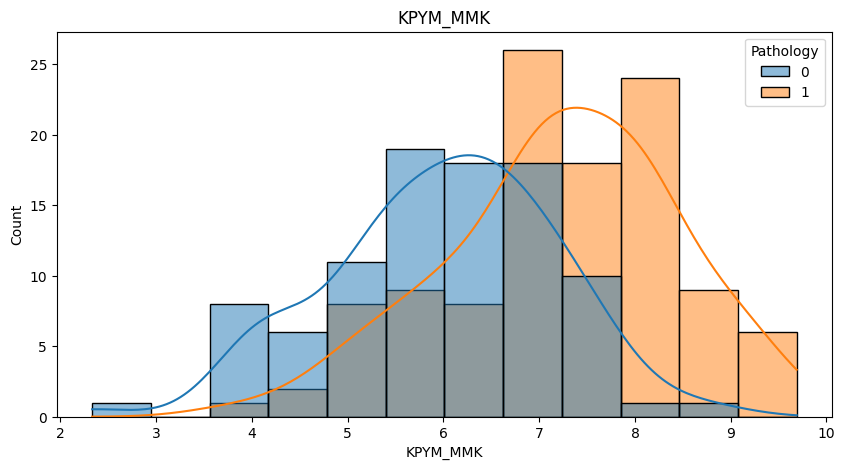

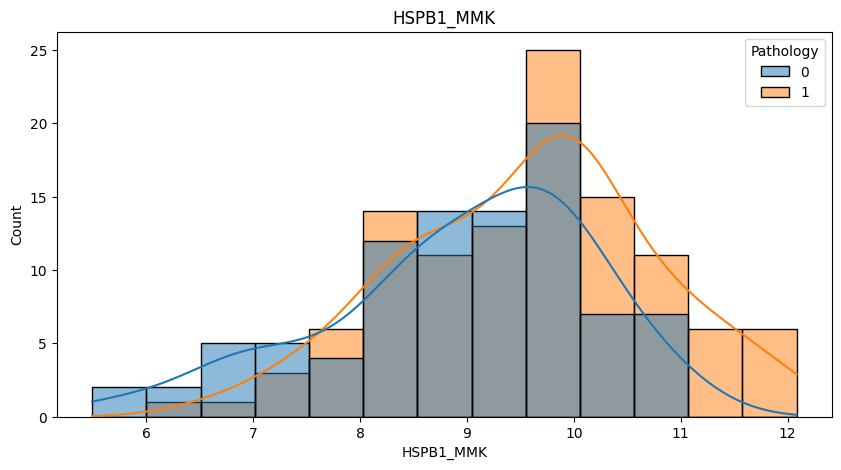

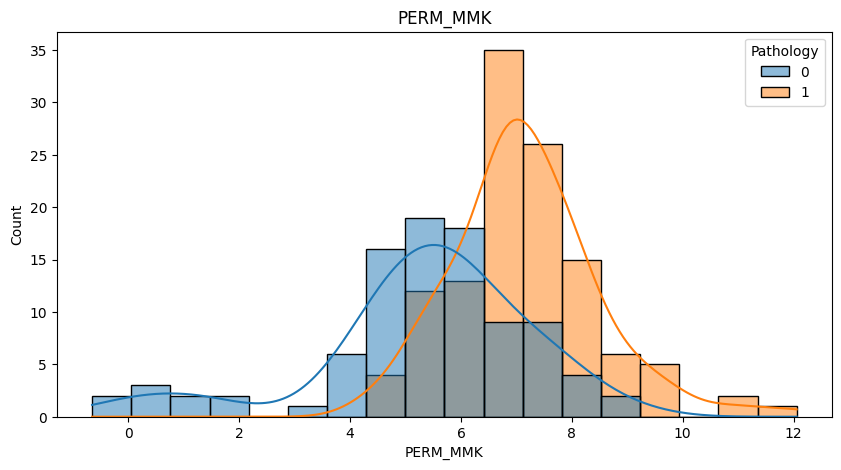

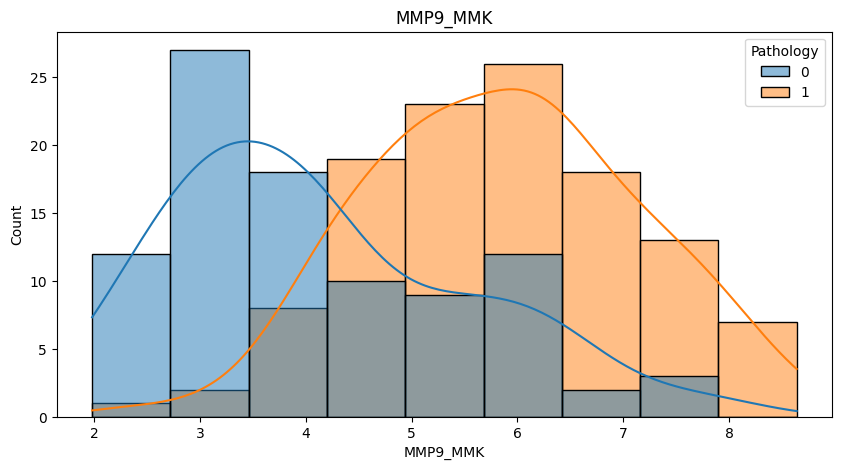

In [20]:
for biomarker in BIOMARKERS_240:
    df_240_log = df_240.copy()
    df_240_log[biomarker] = np.log(df_240_log[biomarker])

    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(data=df_240_log, x=biomarker, hue='Pathology', kde=True, ax=ax)
    plt.title(biomarker)
    plt.show()

